In [1]:
from keras import backend as K
import keras
import cv2
from Utils import *
import tensorflow as tf
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import os
import imageio

import pytesseract

import pandas as pd
import string
from string import digits
get_ipython().run_line_magic('matplotlib', 'inline')
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

print(os.listdir("input"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

['Hindi_English_Truncated_Corpus.csv']


<ipython-input-1-16e89748a9d4>:32: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
tf.device('GPU:0')

In [16]:
#Variable Definition
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model

model = load_model('text_detect_model.json')
model.load_weights('text_detect.h5')

def predict_func(model , inp , iou , name):

    ans = model.predict(inp*1./255)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    #img = ((inp + 1)/2)
    img = inp[0]
    im_ = img.copy()
    #plt.imshow(img)
    #plt.show()
    images = []
    #c=1

    for i in boxes:

        i = [int(x) for x in i]
        x_start, x_end, y_start, y_end = i[0], i[2], i[1], i[3]
        images.append(im_[y_start:y_end, x_start:x_end])
        #imageio.imwrite('{}test.jpg'.format(str(c)), im_[y_start:y_end, x_start:x_end])
        #print([x_start, x_end, y_start, y_end])
        #c+=1

        img = cv2.rectangle(img , (x_start, y_start) , (x_end, y_end) , color = (0,255,0) , thickness = 2)
        
    plt.imshow(img)
    plt.show()
    #imageio.imwrite('yolo_out{}.jpg'.format(str(np.random.randint(0, 100))), img)
    
    return images
    #cv2.imwrite(os.path.join('Results1' , str(name) + '.jpg') , img*255.0)

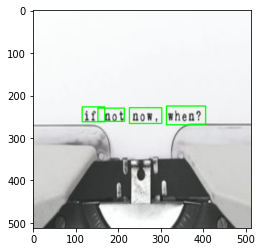

[['\x0c', 'not\n\x0c', 'now,\n\x0c', 'when?\n\x0c'], ['\x0c', 'not\n\x0c', 'it\n\x0c', 'LL ke\n\x0c'], ['\x0c', 'not\n\x0c', 'now,\n\x0c', 'when?\n\x0c']]


In [134]:
#YOLO + Tesseract

img = imageio.imread('good_images/sample3.jpg')
img = cv2.resize(img,(512,512))
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#_, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#img = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)

#img = (img - 127.5)/127.5
results = predict_func(model , np.expand_dims(img,axis= 0) , 0.5 , 'yolo_out')

texts = [[], [], []]
for img in results:
    try:
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #_, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        _, thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        _, thresh2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img1 = cv2.cvtColor(thresh1,cv2.COLOR_GRAY2RGB)
        img2 = cv2.cvtColor(thresh2,cv2.COLOR_GRAY2RGB)
        texts[0].append(pytesseract.image_to_string(img, lang='eng'))
        texts[1].append(pytesseract.image_to_string(img1, lang='eng'))
        texts[2].append(pytesseract.image_to_string(img2, lang='eng'))
    except:
        continue
print(texts)

In [126]:
#Only Tesseract no YOLO

texts=[]
img = imageio.imread('good_images/sample3.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_, thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
_, thresh2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img1 = cv2.cvtColor(thresh1,cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(thresh2,cv2.COLOR_GRAY2RGB)
texts.append(pytesseract.image_to_string(img, lang='eng'))
texts.append(pytesseract.image_to_string(img1, lang='eng'))
texts.append(pytesseract.image_to_string(img2, lang='eng'))
print(texts)
texts = [x.split(' ') for x in texts]

['if not now, when?\n\n:\n\n   \n \n\x0c', 'my Td\n\n \n\x0c', '+ when?\n\n \n\x0c']


In [6]:
exclude = set(string.punctuation) # Set of all special characters

In [135]:
sentence = []
for text in texts:
    sent = ''
    for t in text:
        t = t.replace('\n', ' ')
        t = t.replace('\x0c', ' ')
        t = t.strip()
        if t:
            if sent:
                sent += ' '
            sent += t.lower()

    a = ''
    for ch in sent:
        if (ord(ch)>=97 and ord(ch)<=122) or ord(ch)==32:
            a += ch
    sentence.append(a)

digits = '0123456789'
for ch in exclude:
    sentence = sentence.replace(ch, '')
for ch in digits:
    sentence = sentence.replace(ch, '')

In [136]:
sentence

['not now when', 'not it ll ke', 'not now when']

In [9]:
lines=pd.read_csv("input/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

lines=lines[lines['source']=='ted']

lines=lines[~pd.isnull(lines['english_sentence'])]

lines.drop_duplicates(inplace=True)

lines=lines.sample(n=25000,random_state=42)

# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))


lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]

max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)

num_decoder_tokens += 1 #for zero padding

input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

lines = shuffle(lines)

X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

latent_dim=300

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

model.load_weights('nmt_weights.h5')

# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [129]:
#inal_sentence = set(sentence.split(' ')).intersection(all_eng_words)
final_sentences = []
for s in sentence:
    f_sentence = []
    for f in s.split(' '):
        if {f}.issubset(all_eng_words):
            f_sentence.append(f)
    sent = ''
    sentences = []
    i=1
    num = len(f_sentence)
    for j, word in enumerate(f_sentence):
        if sent:
            sent += ' '
        sent += word
        if i>8 or j==num-1:
            i=1
            sentences.append(sent)
            sent = ''
        i += 1
    final_sentences.append(sentences)

In [130]:
max_value = -1
for f in final_sentences:
    value = len(f)
    for sub_f in f:
        value *= len(sub_f)
    if value>max_value:
        max_value = value
        final_sentence = f

In [131]:
final_sentence

['if not now when']

In [132]:
r_gen = generate_batch(final_sentence, ['START_  _END']*len(final_sentence), batch_size = 1)
k=-1

In [133]:
while k<len(final_sentence)-1:
    k+=1
    (input_seq, actual_output), _ = next(r_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('English sentence: ', final_sentence[k])
    print('Predicted Hindi Translation:', decoded_sentence[:-4])

English sentence:  if not now when
Predicted Hindi Translation:  अगर अब आप नहीं तो 


In [ ]:
from PyDictionary import PyDictionary
dictionary=PyDictionary()

In [ ]:
if dictionary.meaning('  ', disable_errors=True):
    print('dft')
else:
    print('kgy')
print("no error")